In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import seaborn as sns
from datetime import timedelta, datetime


dir = Path(r"S:\Fackler_OSS_364376\data\IRB-364376-v1-230215")

In [3]:
fp = dir.joinpath('EHR', 'd_flo_measures.csv.gz')
dict = pd.read_csv(fp, compression="gzip")
# dict.head()
# dict['disp_name'].unique

names = ["State Behavioral Scale",
"-3 Unresponsive", 
"-2 Responsive to noxious stimuli", 
"-1 Responsive to gentle touch or voice",
"0 Awake and Able to calm",
"+1 Restless and difficult to calm",
"+2 Agitated",
"State Behavioral Scale (SBS)"]

dict[dict['disp_name'].isin(names)]

,flo_meas_id,flo_meas_name,site_row_id,record_state_c,allow_comp_yn,disp_name,abbr_p,row_typ_c,chg_trg_type_c,val_type_c,...,flo_row_status_c,row_type,val_type,cross_enc_yn,question_id,question_prompt,question_required_yn,context_c,store_calc_data_yn,show_abbr_c
64810,304080015,G JHM IP PEDS STATE BEHAVIORAL SCALE,NaN,NaN,NaN,State Behavioral Scale,NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN
64811,304080016,R JHM IP AD PEDS SB UNRESPONSIVE,NaN,NaN,NaN,-3 Unresponsive,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64812,304080017,R JHM IP AD PEDS SB RESPONSIVE TO NOXIOUS STIMULI,NaN,NaN,NaN,-2 Responsive to noxious stimuli,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64813,304080018,R JHM IP AD PEDS SB RESPONSIVE TO GENTLE TOUCH...,NaN,NaN,NaN,-1 Responsive to gentle touch or voice,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64814,304080019,R JHM IP AD PEDS SB AWAKE AND ABLE TO CALM,NaN,NaN,NaN,0 Awake and Able to calm,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64815,304080020,R JHM IP AD PEDS SB RESTLESS AND DIFFICULT TO ...,NaN,NaN,NaN,+1 Restless and difficult to calm,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64816,304080021,R JHM IP AD PEDS SB AGITATED,NaN,NaN,NaN,+2 Agitated,NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
64817,304080022,G JHM IP AD PEDS STATE BEHAVIORAL SCALE (SBS),NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN
64818,304080023,R JHM IP AD PEDS STATE BEHAVIORAL SCALE (SBS),NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,1.0,NaN,8.0,...,0.0,Data,Custom List,N,NaN,NaN,NaN,1.0,NaN,NaN
66624,1570400708,G BH STATE BEHAVIORAL SCALE,NaN,NaN,NaN,State Behavioral Scale (SBS),NaN,2.0,NaN,NaN,...,0.0,Flowsheet Group,NaN,N,NaN,NaN,NaN,1.0,NaN,NaN


In [7]:
# note: flowsheet record flow_meas_id as meas_id
# note: SBS score values are only stored in these fields

fmid = [304080016, 304080017, 304080018, 304080019, 304080020, 304080021]

In [4]:
# connect with feather file
fp = dir.joinpath('EHR', 'ptsd_record.csv.gz')

ptsd_record = pd.read_csv(fp, compression="gzip")
# print(ptsd_record.dtypes)
# ptsd_record.head(2)
patients_ptsd = ptsd_record['pat_enc_csn_sid'].unique()

# load flow table of all patient EHR records
fp = dir.joinpath('EHR', 'flowsheet.csv.gz')

data = pd.read_csv(fp, compression="gzip")
data = data.drop(columns = ['meas_comment', 'meas_template_id'])
# Note: pandas took 50 seconds to load the table. Consider porting to PySpark RDD

In [8]:
# print(data.dtypes)
sbs = data[data['meas_id'].isin(fmid)]
print(sbs.shape)
# 25878 entries

# calculate sbs score from offset
sbs['SBS'] = sbs['meas_id'] - 304080019
sbs = sbs.drop(columns=['meas_value', 'meas_id'])
sbs['recorded_time'] = pd.to_datetime(sbs['recorded_time'], format='%Y-%m-%d %H:%M:%S')
sbs_indiv = sbs.groupby('pat_enc_csn_sid')

# Identify patients with SBS and waveform data
patients_ehr = list(sbs_indiv.groups.keys())

patients = list(set(patients_ehr) & set(patients_ptsd))
print(len(patients))
# 581 patients with both EHR and waveform

(25878, 5)
581


c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Approach 1
Combine SBS and waveforms into a single pandas dataframe

In [9]:
patients

[1000001694,
 1000001695,
 1000001708,
 1000001711,
 1000001718,
 1000001719,
 1000001728,
 1000001756,
 1000001806,
 1000001819,
 1000001857,
 1000001860,
 1000001986,
 1000001988,
 1000001995,
 1000002003,
 1000002007,
 1000002008,
 1000002017,
 1000002020,
 1000002025,
 1000002034,
 1000000003,
 1000002052,
 1000000019,
 1000000025,
 1000000026,
 1000000029,
 1000000030,
 1000000031,
 1000000033,
 1000002082,
 1000002083,
 1000002087,
 1000002098,
 1000002101,
 1000000060,
 1000002111,
 1000002112,
 1000002121,
 1000002123,
 1000002139,
 1000000092,
 1000000096,
 1000002148,
 1000002151,
 1000002154,
 1000002155,
 1000002157,
 1000002158,
 1000000109,
 1000002160,
 1000002161,
 1000002164,
 1000000117,
 1000002165,
 1000002167,
 1000002168,
 1000002169,
 1000002170,
 1000002172,
 1000002174,
 1000000128,
 1000002176,
 1000002177,
 1000002179,
 1000002178,
 1000002180,
 1000002182,
 1000002183,
 1000002181,
 1000002185,
 1000000137,
 1000002187,
 1000002186,
 1000002184,
 1000002190,

In [10]:
p = patients[0]

files = ptsd_record[ptsd_record['pat_enc_csn_sid'] == p]
files['start_time'] = pd.to_datetime(files['start_time'], format='%Y-%m-%d %H:%M:%S')
files['end_time'] = pd.to_datetime(files['end_time'], format='%Y-%m-%d %H:%M:%S')
files.sort_values('start_time')

devices = files['device']
filename = files['filename'] + '.feather'
startime = files['start_time']

dfs = []

for (d, fn, t0) in zip(devices, filename, startime):
    fp_device = 'vitals-' + d.lower()
    fp_p = str(p)[-3:] # last 3 digit of pat_enc_csn_sid is the subfolder
    fp = dir.joinpath('ptsd-phi', fp_device, fp_p, fn)
    
    # add datetime overlap handling
    df = pd.read_feather(fp, columns=None, use_threads=True, storage_options=None)
    df['delta'] = pd.to_timedelta(df['dts'], unit='s')
    df['recorded_time'] = df['delta'] + t0
    
    # df presents time as delta seconds
    dfs.append(df)
patient_multi = pd.concat(dfs, axis=0)

# add SBS
sbs_p = sbs_indiv.get_group(p).sort_values('recorded_time')
sbs_p = sbs_p.drop(columns=['osler_sid', 'pat_enc_csn_sid'])

patient_merged = pd.merge(patient_multi, sbs_p, how='left')
patient_merged = patient_merged.sort_values(by = ['recorded_time'])

print(patient_merged['SBS'].unique())
print(patient_merged.columns)
patient_merged.head(4)

c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[-1. nan  0.]
Index(['dts', 'AR1-D', 'AR1-M', 'AR1-R', 'AR1-S', 'CVP2', 'HR', 'NBP-D',
       'NBP-M', 'NBP-R', 'NBP-S', 'PVC', 'RR', 'SPO2-%', 'SPO2-R', 'delta',
       'recorded_time', 'SBS'],
      dtype='object')


,dts,AR1-D,AR1-M,AR1-R,AR1-S,CVP2,HR,NBP-D,NBP-M,NBP-R,NBP-S,PVC,RR,SPO2-%,SPO2-R,delta,recorded_time,SBS
1780,0.0,42.0,52.0,106.0,70.0,9.0,106.0,NaN,NaN,NaN,NaN,0.0,22.0,99.0,106.0,0 days 00:00:00,2017-07-08 00:00:00,-1.0
1781,1.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0,49.0,110.0,71.0,NaN,NaN,NaN,NaN,0 days 00:00:01,2017-07-08 00:00:01,NaN
1782,60.0,42.0,52.0,104.0,70.0,9.0,104.0,NaN,NaN,NaN,NaN,0.0,24.0,99.0,106.0,0 days 00:01:00,2017-07-08 00:01:00,NaN
1783,120.0,42.0,52.0,106.0,70.0,9.0,108.0,NaN,NaN,NaN,NaN,0.0,24.0,99.0,106.0,0 days 00:02:00,2017-07-08 00:02:00,NaN


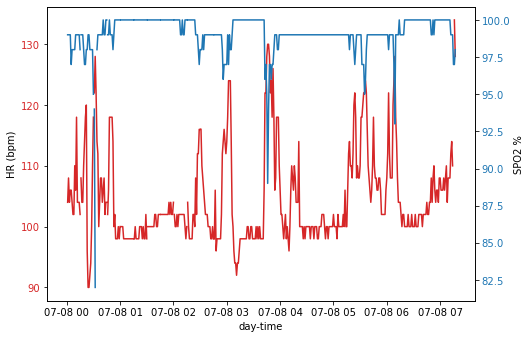

Text(0, 0.5, 'SBS')

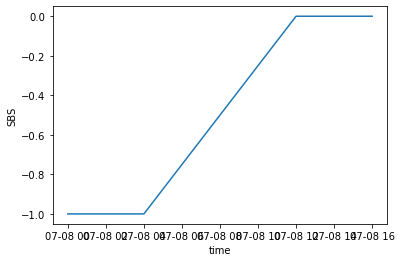

In [11]:
# plot some data from the table
testdata = patient_merged[0:450]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color = 'tab:red'
ax1.plot(testdata['recorded_time'], testdata['HR'], color=color)
ax1.set_xlabel('day-time')
ax1.set_ylabel('HR (bpm)')
ax1.tick_params(axis='y', labelcolor=color)
color = 'tab:blue'
ax2.plot(testdata['recorded_time'], testdata['SPO2-%'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('SPO2 %')
fig.tight_layout()
fig.set_size_inches(8,5)
plt.show()

mask = patient_merged['SBS'].isna()
plt.plot(patient_merged['recorded_time'][~mask], patient_merged['SBS'][~mask])
plt.xlabel('time')
plt.ylabel('SBS')

### Segment pstd and SBS data for ML training

In [12]:
# 581 patients with SBS and vitals
len(patients)

581

#### Select relevant vitals

In [13]:

fp_hl7m = dir.joinpath('ptsd-phi', 'vitals-hl7m', "003", '1000000003-2016-07-07-0.0166667-1-HL7M.feather')
fp_tsdb = dir.joinpath('ptsd-phi', 'vitals-tsdb', "106", '1000002106-2019-01-22-1-TSDB.feather')
fp_gevital = dir.joinpath('ptsd-phi', 'vitals-sb', "672", '1000002672-2020-10-01-1-GEVITAL.feather')
fp_medibus = dir.joinpath('ptsd-phi', 'vitals-sb', "672", '1000002672-2020-10-01-1-MEDIBUSVITAL.feather')

df = pd.read_feather(fp_hl7m, columns=None, use_threads=True, storage_options=None)
names_hl7m = df.columns.tolist()
print("hl7m", names_hl7m)
df = pd.read_feather(fp_tsdb, columns=None, use_threads=True, storage_options=None)
names_tsdb = df.columns.tolist()
print("tsdb", names_tsdb)
df = pd.read_feather(fp_gevital, columns=None, use_threads=True, storage_options=None)
names_gevitals = df.columns.tolist()
print("gevitals", names_gevitals)
df = pd.read_feather(fp_medibus, columns=None, use_threads=True, storage_options=None)
names_medibus = df.columns.tolist()
print("medibus", names_medibus)

hl7m ['dts', 'AR1-D', 'AR1-M', 'AR1-R', 'AR1-S', 'CVP2', 'HR', 'NBP-D', 'NBP-M', 'NBP-R', 'NBP-S', 'PVC', 'RR', 'SPO2-%', 'SPO2-R', 'ST-AVF', 'ST-AVL', 'ST-AVR', 'ST-I', 'ST-II', 'ST-III', 'ST-V1', 'TP1-1', 'TP1-2']
tsdb ['dts', 'HR', 'HR_Art_2930', 'HR_SpO2_7876', 'Temp', 'awRR_3495', 'N2O_Insp_2885', 'N2O_Exp_2886', 'O2_Insp_2902', 'O2_Exp', 'Des_Insp', 'Des_Exp_594', 'Sevo_Insp', 'Sevo_Exp_596', 'SpO2_7874', 'ECG_I_ST', 'ECG_II_ST', 'ECG_III_ST', 'FIO2_2343', 'PIP_1227', 'PEEP_1418', 'NIBP_S', 'ABP_S_2318', 'ABP_D_2319', 'ABP_M_2320', 'CO2_Insp_perc', 'EtCO2_2905', 'NIBP_D', 'NIBP_M']
gevitals ['dts', 'PARM_HR', 'PARM_PVC', 'PARM_ST_SEG1', 'PARM_ST_SEG2', 'PARM_ST_SEG3', 'PARM_ST_V1', 'PARM_ST_V2', 'PARM_ST_V3', 'PARM_ST_V4', 'PARM_ST_V5', 'PARM_ST_V6', 'PARM_ST_AVF', 'PARM_ST_AVL', 'PARM_ST_AVR', 'PARM_SPO2_1', 'PARM_SPO2_HR1', 'PARM_NBP_CUFF', 'PARM_NBP_SYS', 'PARM_NBP_MEAN', 'PARM_NBP_DIA', 'GE_HSDI_SIGNAL_ID_NON_INVASIVE_PRESS_pulseRate_NUM', 'PARM_RESP_RATE', 'GE_HSDI_SIGNAL_ID

For now:
- drop data from Medibus
- Keep dts, HR, SPO2, RR, 

In [14]:
hl7m_order = ['dts', 'HR', 'RR', 'SPO2-%']
tsdb_order = ['dts', 'HR', 'awRR_3495', 'SpO2_7874']
ge_order = ['dts','PARM_HR', 'PARM_RESP_RATE', 'PARM_SPO2_HR1']
metrics = set(hl7m_order + tsdb_order + ge_order)

In [48]:
X = []
y = []
#time_bin = []
patient_time_bin = {}
#temp_patients = [patients[0]] #temp array to look at one patient of interest

# define column header for devices
hl7m_order = ['dts', 'HR', 'RR', 'SPO2-%']
tsdb_order = ['dts', 'HR', 'awRR_3495', 'SpO2_7874']
ge_order = ['dts','PARM_HR', 'PARM_RESP_RATE', 'PARM_SPO2_HR1']
metrics = set(hl7m_order + tsdb_order + ge_order)

for p in patients[10:20]#temp_patients #patients[0:10]
    files = ptsd_record[ptsd_record['pat_enc_csn_sid'] == p]
    files['start_time'] = pd.to_datetime(files['start_time'], format='%Y-%m-%d %H:%M:%S')
    files['end_time'] = pd.to_datetime(files['end_time'], format='%Y-%m-%d %H:%M:%S')
    files.sort_values('start_time')

    devices = files['device']
    filename = files['filename'] + '.feather'
    startime = files['start_time']

    dfs = []
    size = 0 
    for (d, fn, t0) in zip(devices, filename, startime): 
        # drop 'MEDIBUSVITAL' for now
        if fn.endswith('MEDIBUSVITAL.feather'):
            continue
        # HL7M', 'TSDB', 'GEVITAL'
        if (d.endswith('HL7M') or d.endswith('TSDB')):
            fp_device = 'vitals-' + d.lower()
        else:
            fp_device = 'vitals-sb'
        fp_p = str(p)[-3:] # last 3 digit of pat_enc_csn_sid is the subfolder
        fp = dir.joinpath('ptsd-phi', fp_device, fp_p, fn)
        if (fp == None):
            print(fp, "does not exist")
            continue

        df = pd.read_feather(fp, columns=None, use_threads=True, storage_options=None)
        df = df.filter(metrics)
        # rearrange columns according to device
        if d.endswith('HL7M'):
            df = df.reindex(columns=hl7m_order)
        elif d.endswith('TSDB'):
            df = df.reindex(columns=tsdb_order)
        elif d.endswith('GEVITAL'):
            df = df.reindex(columns=ge_order)

        df.loc[:,'dts'] = pd.to_timedelta(df.loc[:,'dts'], unit='s')
        df.loc[:,'dts'] = df.loc[:,'dts'] + t0
        dfs.append(df)
    patient_multi = pd.concat(dfs, axis=0) 
    patient_multi = patient_multi.sort_values(by=['dts'])

    # add SBS
    sbs_p = sbs_indiv.get_group(p).sort_values('recorded_time')
    sbs_p = sbs_p.drop(columns=['osler_sid', 'pat_enc_csn_sid'])

    # slice into X and y array
    for i in range(len(sbs_p)):
        t1 = sbs_p['recorded_time'].iloc[i]
        t0 = t1 - timedelta(seconds=30*60) # 30 minutes prior

        dat = patient_multi.loc[(patient_multi['dts'] >= t0)
                        & (patient_multi['dts'] <= t1)]
        # drop rows with non-constant time intervals
        t_diff = dat['dts'].diff()
        #time_bin.append(t_diff.values.tolist())
        patient_time_bin[p] = t_diff.values.tolist()
        # force all time interval to be constant - TASK: investigate a different way to do this s.t. we don't lose as much data 
        dat = dat[t_diff == pd.Timedelta(60,unit="S")].reset_index(drop=True)
        # sample to 30
        if (dat.shape[0] > 29 and dat.shape[1] == 4):
            X.append(dat.drop(columns=['dts']).to_numpy())
            y.append(sbs_p.iloc[i,1])

X = np.array(X)
y = np.array(y)

c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [50]:
# visualize data frame for one patient using temp array
patient_multi

,dts,HR,RR,SPO2-%
0,2017-07-08 00:00:00,106.0,22.0,99.0
1,2017-07-08 00:00:01,NaN,NaN,NaN
2,2017-07-08 00:01:00,104.0,24.0,99.0
3,2017-07-08 00:02:00,108.0,24.0,99.0
4,2017-07-08 00:03:00,104.0,22.0,99.0
...,...,...,...,...
626,2017-07-10 10:23:00,114.0,37.0,92.0
627,2017-07-10 15:16:00,118.0,24.0,NaN
628,2017-07-10 15:17:00,122.0,32.0,NaN
629,2017-07-10 15:18:00,124.0,30.0,NaN


In [15]:
# replace missing data with unphysiological value
X = np.nan_to_num(X, nan=-1)

# reshape
X = np.transpose(X, (0, 2, 1))

print(X.shape)
print(y.shape)

np.save('./DONOTPUSH/waveforms.npy',X)
np.save('./DONOTPUSH/sbs.npy',y)

(5612, 30, 3)
(5612,)


In [16]:
X = np.load('./DONOTPUSH/waveforms.npy')
y = np.load('./DONOTPUSH/sbs.npy')

(array([ 142.,    0.,  337.,    0., 1005.,    0., 3185.,    0.,  508.,
         435.]),
 array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <BarContainer object of 10 artists>)

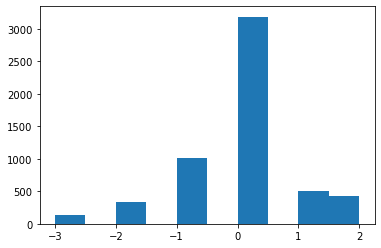

In [17]:
plt.hist(y)

Looking into time frequency problem

(array([5.810e+02, 4.800e+01, 3.900e+01, 5.582e+03, 0.000e+00, 1.000e+00,
        2.300e+01, 0.000e+00, 0.000e+00, 4.000e+00]),
 array([0.00e+00, 1.80e+10, 3.60e+10, 5.40e+10, 7.20e+10, 9.00e+10,
        1.08e+11, 1.26e+11, 1.44e+11, 1.62e+11, 1.80e+11]),
 <BarContainer object of 10 artists>)

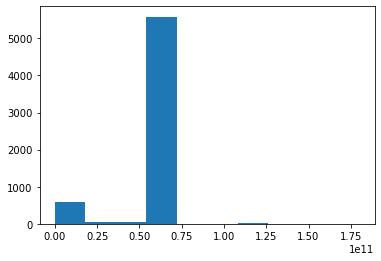

In [18]:
flat_time_bin = [item for sublist in time_bin for item in sublist]
flat_time_bin = [i for i in flat_time_bin if i is not None]
flat_time_bin
plt.hist(flat_time_bin)

* anything less than 0.25e11 is dropped definitely 
* anything within +/- a given delta should include - what should this delta be? - need to optimize
* anything over delta + 60s down sample --> look into downsampling methods

In [ ]:
for i in range(len(flat_time_bin)):
    if(flat_time_bin[i] > 0.25e11):
        


attempt to do hist by patient for first ten patients see if most of extraneous values are coming from same patient


In [21]:
pat = patients[0:10]
patient_time_bin[pat[0]]

[None,
 0,
 60000000000,
 0,
 60000000000,
 0,
 59000000000,
 1000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 57000000000,
 3000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0,
 60000000000,
 0]

(array([33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.]),
 array([0.0e+00, 6.0e+09, 1.2e+10, 1.8e+10, 2.4e+10, 3.0e+10, 3.6e+10,
        4.2e+10, 4.8e+10, 5.4e+10, 6.0e+10]),
 <BarContainer object of 10 artists>)

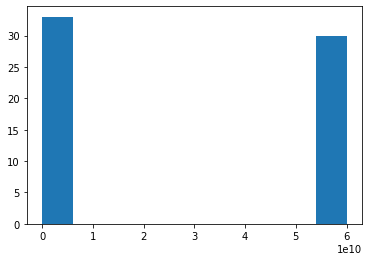

In [25]:
#flat_time_bin1 = [item for sublist in patient_time_bin[pat[0]] for item in sublist]
#flat_time_bin1 = [i for i in flat_time_bin1 if i is not None]
#flat_time_bin1
#plt.hist(flat_time_bin1)

flat_time_bin1 = [i for i in patient_time_bin[pat[0]] if i is not None]
plt.hist(flat_time_bin1)

Text(0.5, 1.0, 'Patient 1000001819')

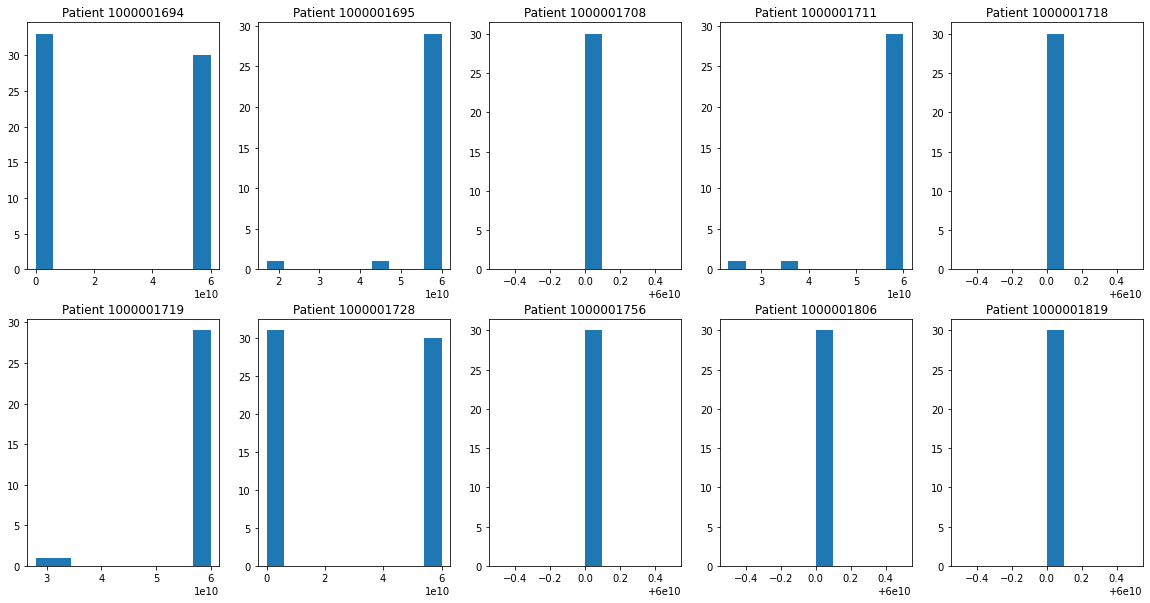

<Figure size 720x360 with 0 Axes>

In [45]:
p_first_10 = patients[0:10]
clean_time_bin = {}

for pat in range(len(p_first_10)):
    clean_time_bin[pat] = [i for i in patient_time_bin[p_first_10[pat]] if i is not None]

fig, axs = plt.subplots(2,5, figsize = (20,10))
plt.figure(figsize = (10,5))
axs[0, 0].hist(clean_time_bin[0])
axs[0, 0].set_title('Patient ' + str(patients[0]))
axs[0, 1].hist(clean_time_bin[1])
axs[0, 1].set_title('Patient ' + str(patients[1]))
axs[0, 2].hist(clean_time_bin[2])
axs[0, 2].set_title('Patient ' + str(patients[2]))
axs[0, 3].hist(clean_time_bin[3])
axs[0, 3].set_title('Patient ' + str(patients[3]))
axs[0, 4].hist(clean_time_bin[4])
axs[0, 4].set_title('Patient ' + str(patients[4]))
axs[1, 0].hist(clean_time_bin[5])
axs[1, 0].set_title('Patient ' + str(patients[5]))
axs[1, 1].hist(clean_time_bin[6])
axs[1, 1].set_title('Patient ' + str(patients[6]))
axs[1, 2].hist(clean_time_bin[7])
axs[1, 2].set_title('Patient ' + str(patients[7]))
axs[1, 3].hist(clean_time_bin[8])
axs[1, 3].set_title('Patient ' + str(patients[8]))
axs[1, 4].hist(clean_time_bin[9])
axs[1, 4].set_title('Patient ' + str(patients[9]))
#plt.figure(figsize = (10,15))
#fig.show


#for ax in axs.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')

#plt.hist(flat_time_bin1)

Work to see if where not 30 readings if still 1 min or weird time intervals

In [56]:
freq_of_samples = [0]*10
for i in range(10):
    freq_of_samples[i] = len(clean_time_bin[i])
freq_of_samples
# only 60 and 30 cases (63, 31, 61, 30) in first ten

[63, 31, 30, 31, 30, 31, 61, 30, 30, 30]

first 10 patients only show freq of 30, 31, 61, 63 - we know that patient[0] has 1 min intervals for time diff near 60 and others are 0

#### ML pipeline

(array([ 142.,    0.,  337.,    0., 1005.,    0., 3185.,    0.,  508.,
         435.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

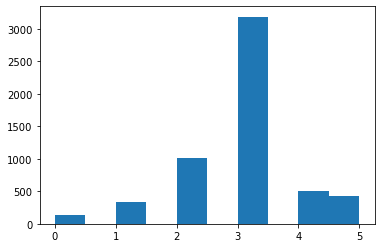

In [ ]:
# shift SBS label: multiclass classifier needs labels to start from 0
y += 3
plt.hist(y)

In [ ]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket
import xgboost as xgb

# preserve class ratio in train and test set
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)

# verify that training and test groups have the same class distribution
# plt.hist(y_train)
# plt.show()
# plt.hist(y_test)

(4489, 3, 30)
(4489,)


XGBoost:
- [Workflow tutorial](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
- [Hyperparameter list](https://xgboost.readthedocs.io/en/stable/parameter.html)

- [Hyperparameter tuning tutorial (Section 2)](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663)

In [ ]:
rocket = Rocket()
rocket.fit(X_train)
# transform patient waveform into features using ROCKET
X_train_transform = rocket.transform(X_train)
X_test_transform = rocket.transform(X_test)

In [ ]:
# use a simple linear classifier with regularization
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, y_train)
classifier.score(X_test_transform, y_test)

0.4541406945681211

In [ ]:
# use xgboost classifier
dtrain = xgb.DMatrix(X_train_transform, label=y_train)
dtest = xgb.DMatrix(X_test_transform, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

param = {'max_depth': 4, 
         'learning_rate': 0.1,
         'colsample_bytree': 1,
         'subsample': 0.9,
         'objective': 'multi:softmax', 
         'num_class': 6}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 100

bst = xgb.train(param, dtrain, num_round, evallist)

# observe that as train AUC increase, eval AUC decrease
# this indicates model overfitting (or the data is fundamentally different)
# more model tuning is required

[0]	train-auc:0.67565	eval-auc:0.57278
[1]	train-auc:0.71967	eval-auc:0.59598
[2]	train-auc:0.75043	eval-auc:0.61454
[3]	train-auc:0.76686	eval-auc:0.60856
[4]	train-auc:0.77866	eval-auc:0.61034
[5]	train-auc:0.79031	eval-auc:0.61257
[6]	train-auc:0.80635	eval-auc:0.61284
[7]	train-auc:0.81492	eval-auc:0.61828
[8]	train-auc:0.82381	eval-auc:0.61272
[9]	train-auc:0.83327	eval-auc:0.61013
[10]	train-auc:0.84347	eval-auc:0.60763
[11]	train-auc:0.85344	eval-auc:0.60855
[12]	train-auc:0.86246	eval-auc:0.60768
[13]	train-auc:0.86939	eval-auc:0.61074
[14]	train-auc:0.87599	eval-auc:0.60976
[15]	train-auc:0.88121	eval-auc:0.60898
[16]	train-auc:0.88686	eval-auc:0.61013
[17]	train-auc:0.89363	eval-auc:0.61305
[18]	train-auc:0.90074	eval-auc:0.61643
[19]	train-auc:0.90727	eval-auc:0.61530
[20]	train-auc:0.91262	eval-auc:0.61408
[21]	train-auc:0.91694	eval-auc:0.61957
[22]	train-auc:0.92269	eval-auc:0.61858
[23]	train-auc:0.92673	eval-auc:0.61848
[24]	train-auc:0.93183	eval-auc:0.62022
[25]	train